In [104]:
import scipy.io
from scipy import signal
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

In [2]:
directory = "C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database"
#directory = "D:\\DATASET FVAB\\SEED_IV Database\\SEED_IV Database\\"

In [3]:
directory

'C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database'

# Original code

In [4]:
path = os.path.join(directory, "eeg_raw_data", "1", "10_20151014.mat")

In [5]:
data = scipy.io.loadmat(path)

In [6]:
#Prende tutti gli header per estrarre i dati
labels = list(data.keys())
size = len(labels)

In [7]:
# Carica il dataset in un dataframe di pandas usando gli header
for i in range(3,size,1):
    df = pd.DataFrame(data[labels[i]])
    print(df.shape)
    #df.transpose()
    #df.to_csv(labels[i]+".csv")

(62, 33601)
(62, 19001)
(62, 39801)
(62, 26001)
(62, 17601)
(62, 32401)
(62, 30601)
(62, 41801)
(62, 29001)
(62, 33801)
(62, 10001)
(62, 22001)
(62, 43401)
(62, 33801)
(62, 51801)
(62, 28201)
(62, 13601)
(62, 35801)
(62, 28001)
(62, 9601)
(62, 22401)
(62, 22401)
(62, 35001)
(62, 27401)


In [8]:
channel_order = pd.read_excel(os.path.join(directory,"Channel Order.xlsx"), header=None)

In [286]:
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
labels = session1_label + session2_label + session3_label

In [10]:
directory = os.path.join(directory, 'eeg_raw_data')

# Drop channels

In [11]:
def drop_channels(df):
    df = df.set_index(channel_order[0])
    df = df.transpose()
    df = df[['FT7','FT8','T7', 'T8', 'TP7', 'TP8']]
    df = df.transpose()
    return df

In [12]:
df_6_channels = drop_channels(pd.DataFrame(data['tyc_eeg1']))

In [13]:
df_6_channels.index.names = ['Channels']

In [14]:
print(df_6_channels.shape)

(6, 33601)


# Downsampling e filtering

In [15]:
def down_sampling(data):
    sfreq = 1000
    new_sfreq = 200
    
    data = signal.resample(data, int(len(data) * new_sfreq / sfreq))    
    return data

In [16]:
def band_pass_filter(data):
    sfreq = 1000
    nyquist_frequency = sfreq / 2
    lowcut = 0.3 
    highcut = 50
    order = 4
       
    b, a = signal.butter(order, [lowcut/nyquist_frequency, highcut/nyquist_frequency], btype='band')
    data = signal.filtfilt(b, a, data, padlen=0)
    return data

<AxesSubplot: >

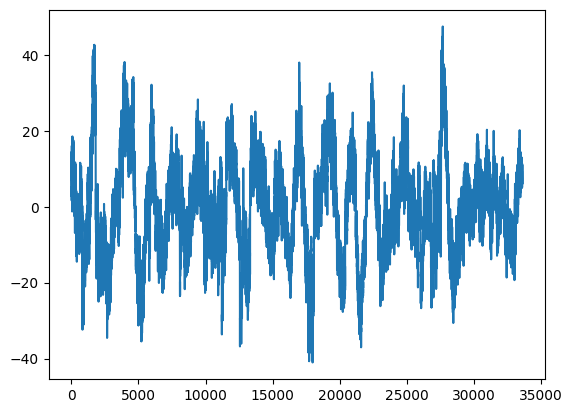

In [17]:
df_6_channels.iloc[3].plot()

In [18]:
processed_data_down = down_sampling(df_6_channels.T)

In [19]:
print(processed_data_down.shape)

(6720, 6)


<AxesSubplot: >

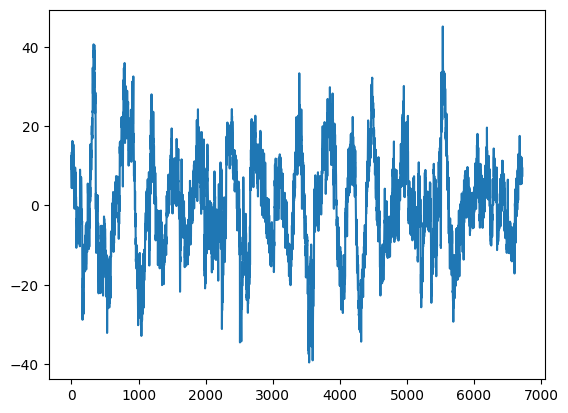

In [20]:
pd.DataFrame(processed_data_down)[3].plot()

In [21]:
processed_data_filter = band_pass_filter(processed_data_down)

In [22]:
print(processed_data_filter.shape)

(6720, 6)


<AxesSubplot: >

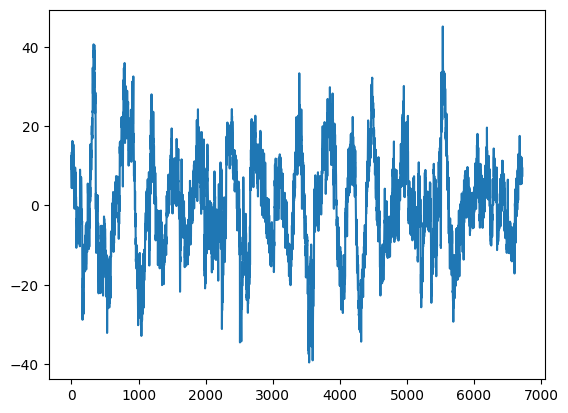

In [23]:
pd.DataFrame(processed_data_down)[3].plot()

In [24]:
filtered_dataset = pd.DataFrame(processed_data_filter).T

In [25]:
filtered_dataset['Channels'] = ['FT7','FT8','T7', 'T8', 'TP7', 'TP8']

In [26]:
filtered_dataset.set_index('Channels',inplace=True)

## Feature Extraction

### PSD

In [184]:
def psd_function(df):
    return signal.welch(df, 50 , nperseg=4000)

In [185]:
f, psd = psd_function(filtered_dataset)

In [186]:
psd.shape

(6, 2001)

In [187]:
f.shape

(2001,)

### DE

In [188]:
def de(df):
    return scipy.stats.differential_entropy(df)

In [189]:
entropy = de(filtered_dataset)

In [190]:
entropy.shape

(6720,)

<AxesSubplot: >

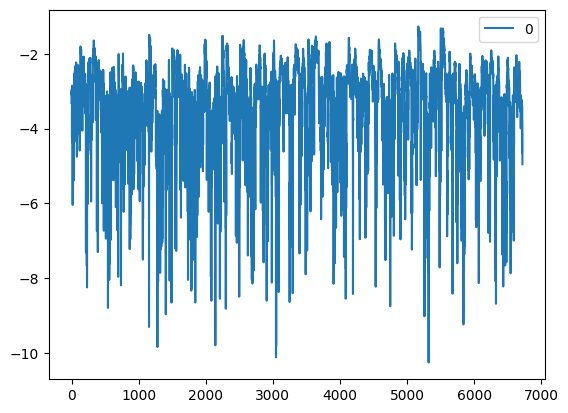

In [191]:
pd.DataFrame(entropy).plot()

### DASM

In [192]:
def dasm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return np.abs(left_hemisphere_psd-right_hemisphere_psd)/(left_hemisphere_psd+right_hemisphere_psd)

In [196]:
dasm = dasm_function(psd)

In [197]:
dasm.shape

(3, 2001)

<AxesSubplot: >

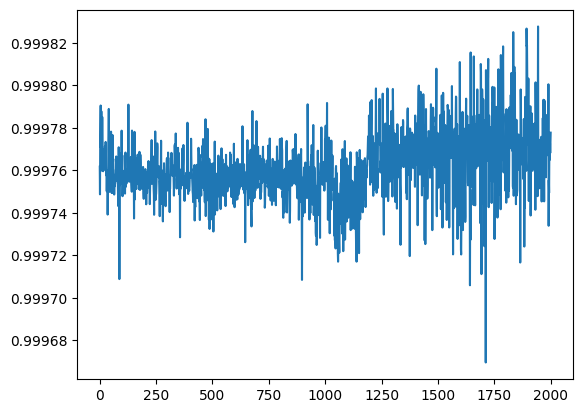

In [198]:
pd.DataFrame(dasm).iloc[2].plot()

### ASM

In [200]:
def asm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return (np.sum(left_hemisphere_psd, axis=0) - np.sum(right_hemisphere_psd, axis=0)) / np.sum(left_hemisphere_psd + right_hemisphere_psd, axis=0)

In [201]:
asm = asm_function(psd)

In [202]:
asm.shape

(2001,)

<AxesSubplot: >

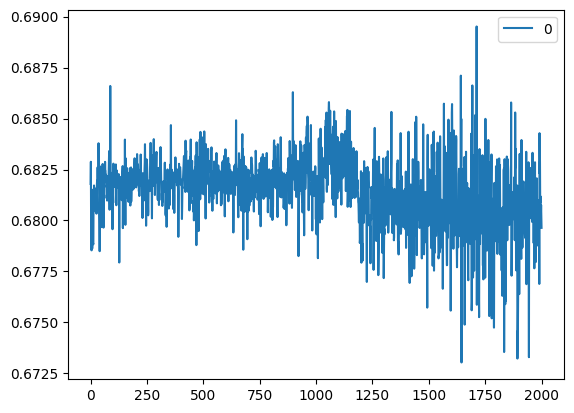

In [203]:
pd.DataFrame(asm).plot()

# Script Feature Extraction

In [262]:
def feature_extraction(df):
    #calcolo psd + de + dasm + asm
    f, psd = psd_function(filtered_dataset)
    entropy = de(filtered_dataset)
    dasm = dasm_function(psd)
    asm = asm_function(psd)
    #combinazione risultati psd + de + dasm + asm (approccio che fa esplodere la dimensionalità del dataset)
    return np.concatenate((psd.flatten(),entropy,dasm.flatten(),asm)) 

In [263]:
result = feature_extraction(filtered_dataset)

In [264]:
result.shape

(63217,)

In [277]:
df = pd.DataFrame(result).T 

In [278]:
df['file'] = ['mat123432'] #placeholder temporaneo (aggiungere anche identificativo utente nella chiave)

In [287]:
df['label'] = labels[0]

In [280]:
df.set_index('file', inplace=True)

In [288]:
df

,0,1,2,3,4,5,6,7,8,9,...,59408,59409,59410,59411,59412,59413,59414,59415,59416,label
file,,,,,,,,,,,,,,,,,,,,,
mat123432,980.20586,5522.709116,17360.602703,17691.373725,7266.525092,5008.591948,5175.679182,3913.030855,2871.498694,3232.860046,...,0.443498,0.445759,0.447751,0.449461,0.450879,0.451991,0.452792,0.453276,0.453436,1


# Concatenazione

In [270]:
df_global = pd.DataFrame()

In [271]:
pd.concat([df_global,df])

,0,1,2,3,4,5,6,7,8,9,...,63208,63209,63210,63211,63212,63213,63214,63215,63216,label
file,,,,,,,,,,,,,,,,,,,,,
mat123432,14.230475,156.75775,524.212485,316.034736,311.541024,368.674631,282.666908,186.191754,211.106203,253.297282,...,-0.116052,-0.115339,-0.114707,-0.114163,-0.113707,-0.113348,-0.113091,-0.112935,-0.112883,__header__


In [272]:
result.shape[0]

63217

# Script

In [273]:
if os.path.exists(directory):
    lista_cartella_main = os.listdir(directory)
    for file in lista_cartella_main:
        sec = os.path.join(directory, file)
        if os.path.isdir(sec):
            files1 = os.listdir(sec)
            for file1 in files1:
                if file1.endswith(".mat"):
                    file1 = os.path.join(sec, file1)
                    data = scipy.io.loadmat(file1)
                    labels = list(data.keys())
                    size = len(labels)
                    print(file1)
                    maximum = 0
                    for i in range(3,size,1):
                        df = pd.DataFrame(data[labels[i]])
                        df = drop_channels(df)
                        downsampled = down_sampling(data[labels[i]])
                        filtered = band_pass_filter(downsampled)
                        filtered_dataset = pd.DataFrame(filtered)
                        result = feature_extraction(filtered_dataset)
                        print(result.shape)
                        if result.shape[0] >= maximum:
                            maximum = result.shape[0]

C:\Users\grazi\Desktop\Materiale FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\10_20151014.mat
(65617,)
(51017,)
(71817,)
(58017,)
(49617,)
(64417,)
(62617,)
(73817,)
(61017,)
(65817,)
(42017,)
(54017,)
(75417,)
(65817,)
(83817,)
(60217,)
(45617,)
(67817,)
(60017,)
(41617,)
(54417,)
(54417,)
(67017,)
(59417,)
C:\Users\grazi\Desktop\Materiale FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\11_20150916.mat
(65617,)
(51017,)
(71817,)
(58017,)
(49617,)
(64417,)
(62617,)
(73817,)
(61017,)
(65817,)
(42017,)
(54017,)
(75417,)
(65817,)
(83817,)
(60217,)
(45617,)
(67817,)
(60017,)
(41617,)
(54417,)
(54417,)
(67017,)
(59417,)
C:\Users\grazi\Desktop\Materiale FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\12_20150725.mat
(65617,)
(51017,)
(71817,)
(58017,)
(49617,)
(64417,)
(62617,)
(73817,)
(61017,)
(65817,)
(42017,)
(54017,)
(75417,)
(65817,)
(83817,)
(60217,)
(45617,)
(67817,)
(60017,)
(41617,)
(54417,)
(54417,)
(67017,)
(59417,)


KeyboardInterrupt: 

In [ ]:
print(maximum)